In [2]:
# imports
import pathlib
import os
import pandas as pd
import cobra
from cobra.flux_analysis import flux_variability_analysis

In [6]:
# get data & model folders
current_dir = pathlib.Path(os.getcwd())
model_dir = current_dir.parent / "models"
validation_data_dir = current_dir / "validation_data"

In [4]:
# save model names
models = {
    "ihuman": "Human-GEM.xml",
    "A375_ftINIT_10": "A375_ftINIT_1+0_thr100_model.xml",
    "A375_ftINIT_11": "A375_ftINIT_1+1_thr100_model.xml",
    "A375_human1_pool_sMOMENT": "A375_human1_sMOMENT_pool_model.xml",
    "A375_human1_sMOMENT": "A375_human1_sMOMENT_model.xml",
    "A375_10_sMOMENT": "A375_1+0_sMOMENT_model.xml",
    "A375_11_sMOMENT": "A375_1+1_sMOMENT_model.xml",
}

In [5]:
# load models one by one (to save RAM), calculate Flux Variability and save the results as tsv
fva_solutions = {}
for model_name, model_path in models.items():
    print(f"*loading model {model_name}*")
    with cobra.io.read_sbml_model(model_dir / model_path) as model:
        print("*caluclating flux variability*")
        df_fva = flux_variability_analysis(model, fraction_of_optimum=0.95)
        print(f"*saving results in 'FVA_solution_{model_name}.tsv'*")
        df_fva.to_csv(validation_data_dir / f"FVA_solution_{model_name}.tsv", sep="\t")
        fva_solutions[model_name] = df_fva
    print("*done*")
    print()

*loading model A375_human1_pool_sMOMENT*
*caluclating flux variability*
*saving results in 'FVA_solution_A375_human1_pool_sMOMENT.tsv'*
*done*



In [7]:
# load the result tsvs in case of restart of the script
fva_solutions = {}
for model_name, model_path in models.items():
    df_fva = pd.read_csv(validation_data_dir / f"FVA_solution_{model_name}.tsv", delimiter="\t", index_col=0)
    fva_solutions[model_name] = df_fva

In [8]:
# the sMOMENT models include several helper reactions that should not be counted in for metabolic flux
# Reactions that need to be left out:
# - ENZYME_DELIVERY_<gene_id> (exchange reaction for input of measured enzyme constraints)
# - ER_pool_TG_ (exchange reaction for input of total enzyme pool constrain for all reactions)
#
# Additionally, reversible reaction fluxes have to be combined:
# - <reaction_id>_TG_forward & <reaction_id>_TG_rv
#
# lastly, isoenzyme reactions are split in the following schema:
# armr_<reaction_id> (exchange reaction for getting rid of a pseudometabolite)
# <reaction_id>_GPRSPLIT_1 (reaction including isoenzyme 1 and producing the pseudometabolite)
# <reaction_id>_GPRSPLIT_2 (reaction including isoenzyme 1 and producing the pseudometabolite)
# <reaction_id>_GPRSPLIT_3 (reaction including isoenzyme 1 and producing the pseudometabolite)
# ...
# the flux range for the arm reaction already includes the flux range for the reaction, 
# so the split reactions are not needed (except if there is no arm reaction for a split reaction)

fva_solutions_mapped = {}

for model_name, fva_solution in fva_solutions.items():
    if "sMOMENT" in model_name:
        if "human1" in model_name:
            template_rxns = fva_solutions["ihuman"].index  # reactions in the model the sMOMENT model was created from
        elif "_10_" in model_name:
            template_rxns = fva_solutions["A375_ftINIT_10"].index  # reactions in the model the sMOMENT model was created from
        elif "_11_" in model_name:
            template_rxns = fva_solutions["A375_ftINIT_11"].index  # reactions in the model the sMOMENT model was created from
        else:
            print(model_name)

        df_sM = fva_solution # reactions & fluxes of the sMOMENT model
        df_mapped = pd.DataFrame(index=template_rxns, columns=["minimum", "maximum"])

        for reaction in df_sM.index:
            # irreversible non-isoenzyme reaction
            if reaction in template_rxns:
                df_mapped.loc[reaction, ["minimum", "maximum"]] = df_sM.loc[reaction, ["minimum", "maximum"]]

            # reversible non-isoenzyme reactions
            # arm reactions, even if reversible, lack the _TG identifier and are thus not included
            elif reaction.endswith("_TG_forward") and not "_GPRSPLIT" in reaction:
                reaction_id = reaction.replace("_TG_forward", "")
                df_mapped.loc[reaction_id, "maximum"] = df_sM.loc[reaction, "maximum"]
                df_mapped.loc[reaction_id, "minimum"] = (df_sM.loc[reaction.replace("forward", "reverse"), "maximum"]) * (-1)

            # isoenzyme reactions 
            # the flux range is the same for the reactions with each isoenzyme, so only the value of the first one is used
            elif "_GPRSPLIT_1" in reaction:
                reaction_id_rev = reaction.replace("_GPRSPLIT_1", "") 

                # reversible isoenzyme reactions 
                if reaction_id_rev.endswith("_forward"):
                    reaction_id = reaction_id_rev.replace("_TG_forward", "")
                    df_mapped.loc[reaction_id, "maximum"] = df_sM.loc[reaction, "maximum"]
                    df_mapped.loc[reaction_id, "minimum"] = (df_sM.loc[reaction.replace("forward", "reverse"), "maximum"]) * (-1)

                # irreversible isoenzyme reactions
                elif not reaction_id_rev.endswith("_reverse"):
                    df_mapped.loc[reaction_id_rev, ["minimum", "maximum"]] = df_sM.loc[reaction, ["minimum", "maximum"]]

        fva_solutions_mapped[model_name] = df_mapped
    else:
        fva_solutions_mapped[model_name] = fva_solution


In [31]:
# the models not only differ in flux variability, but also in their predicted maximum growth rate
fba_solutions = {}
for model_name, model_path in models.items():
    print(f"*loading model {model_name}*")
    with cobra.io.read_sbml_model(model_dir / model_path) as model:
        print("*caluclating objective value*")
        fba_solutions[model_name] = model.slim_optimize()
    print("*done*")
    print()
print(fba_solutions)

*loading model ihuman*
*caluclating objective value*
*done*

*loading model A375_ftINIT_10*
*caluclating objective value*
*done*

*loading model A375_ftINIT_11*
*caluclating objective value*
*done*

*loading model A375_human1_pool_sMOMENT*
*caluclating objective value*
*done*

*loading model A375_human1_sMOMENT*
*caluclating objective value*
*done*

*loading model A375_10_sMOMENT*
*caluclating objective value*
*done*

*loading model A375_11_sMOMENT*
*caluclating objective value*
*done*

{'ihuman': 124.86814837744573, 'A375_ftINIT_10': 124.82912844999419, 'A375_ftINIT_11': 83.86569956691, 'A375_human1_pool_sMOMENT': 7.412502133749626, 'A375_human1_sMOMENT': 1.564702760415956, 'A375_10_sMOMENT': 0.4753331467433929, 'A375_11_sMOMENT': 0.4870004118685573}


In [9]:
for model_name, df in fva_solutions_mapped.items():
    df["variability"] = df["maximum"] - df["minimum"]
    print(model_name)
    print(df)

ihuman
          minimum  maximum  variability
MAR03905      0.0   1000.0       1000.0
MAR03907      0.0   1000.0       1000.0
MAR04097      0.0    175.0        175.0
MAR04099      0.0    175.0        175.0
MAR04108      0.0    175.0        175.0
...           ...      ...          ...
MAR20179      0.0      0.0          0.0
MAR20180      0.0      0.0          0.0
MAR20181  -1000.0   1000.0       2000.0
MAR20182  -1000.0   1000.0       2000.0
MAR20183  -1000.0   1000.0       2000.0

[12971 rows x 3 columns]
A375_ftINIT_10
          minimum  maximum  variability
MAR03905      0.0   1000.0       1000.0
MAR03907      0.0   1000.0       1000.0
MAR04097      0.0    175.0        175.0
MAR04099      0.0    175.0        175.0
MAR04108      0.0    175.0        175.0
...           ...      ...          ...
MAR20177      0.0   1000.0       1000.0
MAR20178      0.0   1000.0       1000.0
MAR20181  -1000.0   1000.0       2000.0
MAR20182  -1000.0   1000.0       2000.0
MAR20183  -1000.0   1000.0      

In [66]:
# simple script for a t-test between all model flux range samples

import scipy.stats as stats
import itertools

# Create an empty DataFrame for p-values
p_value_matrix = pd.DataFrame(index=models.keys(), columns=models.keys())

# Perform t-tests for all unique dataset combinations
for model1, model2 in itertools.combinations(models.keys(), 2):
    model_var1 = fva_solutions_mapped[model1][["variability"]].astype(float)
    model_var2 = fva_solutions_mapped[model2][["variability"]].astype(float)
    t_stat, p_value = stats.ttest_ind(model_var1, model_var2, equal_var=False)  # Independent t-test
    p_value_matrix.loc[model1, model2] = p_value
    p_value_matrix.loc[model2, model1] = p_value  # Mirror values

# Fill diagonal with NaN (since a dataset compared to itself )
p_value_matrix.fillna(1, inplace=True)  # Or set NaN if preferred
p_value_matrix = p_value_matrix.astype(float).round(6)
p_value_matrix.index = ["generic Human1", "ftINIT(1+0)", "ftINIT(1+1)", "sMOMENT(pool)", "sMOMENT", 
    "ftINIT(1+0) & sMOMENT", "ftINIT(1+1) & sMOMENT"]
p_value_matrix.columns = ["generic Human1", "ftINIT(1+0)", "ftINIT(1+1)", "sMOMENT(pool)", "sMOMENT", 
    "ftINIT(1+0) & sMOMENT", "ftINIT(1+1) & sMOMENT"]
# Print or save results
p_value_matrix


,generic Human1,ftINIT(1+0),ftINIT(1+1),sMOMENT(pool),sMOMENT,ftINIT(1+0) & sMOMENT,ftINIT(1+1) & sMOMENT
generic Human1,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000
ftINIT(1+0),0.0,1.0,0.0,0.0,0.0,0.000000,0.000000
ftINIT(1+1),0.0,0.0,1.0,0.0,0.0,0.000000,0.000000
sMOMENT(pool),0.0,0.0,0.0,1.0,0.0,0.000000,0.000000
sMOMENT,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000
ftINIT(1+0) & sMOMENT,0.0,0.0,0.0,0.0,0.0,1.000000,0.651765
ftINIT(1+1) & sMOMENT,0.0,0.0,0.0,0.0,0.0,0.651765,1.000000


In [10]:
import matplotlib.pyplot as plt
import numpy as np

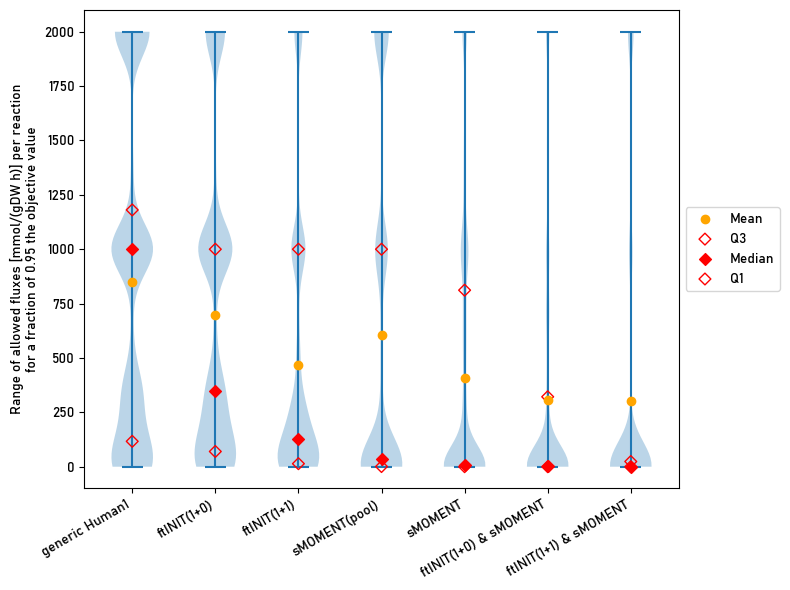

In [39]:
rxn_variability = [df["variability"].astype(float) for df in fva_solutions_mapped.values()]
labels = ["generic Human1", "ftINIT(1+0)", "ftINIT(1+1)", "sMOMENT(pool)", "sMOMENT", 
          "ftINIT(1+0) & sMOMENT", "ftINIT(1+1) & sMOMENT"]

fig, ax = plt.subplots(figsize=(8, 6))

# Create violin plot
parts = ax.violinplot(rxn_variability, showmeans=False, showmedians=False)

# Compute statistics
q1 = [np.percentile(d, 25) for d in rxn_variability]
q3 = [np.percentile(d, 75) for d in rxn_variability]
means = [np.mean(d) for d in rxn_variability]
medians = [np.median(d) for d in rxn_variability]
positions = range(1, len(rxn_variability) + 1)

# Ensure statistics are plotted in the correct order to avoid overlap issues
ax.scatter(positions, means, color="orange", marker="o", zorder=5, label="Mean")  # Means behind quartiles & median
ax.scatter(positions, q3, color="red", facecolors="none", marker="D", zorder=4, label="Q3")  # Q3
ax.scatter(positions, medians, color="red", marker="D", zorder=5, label="Median")  # Median on top
ax.scatter(positions, q1, color="red", facecolors="none", marker="D", zorder=4, label="Q1")  # Q1

# Setting labels and styling
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=30, ha="right", fontname="Bahnschrift")
ax.set_ylabel("Range of allowed fluxes [mmol/(gDW h)] per reaction\nfor a fraction of 0.95 the objective value", fontname="Bahnschrift")

# Move legend to center right, outside the plot
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Apply global font settings
plt.rcParams["font.family"] = "Bahnschrift"

# Adjust layout to prevent clipping
plt.tight_layout()
plt.savefig(current_dir.parent / "outputs" / "fva_violin.svg")
plt.show()


C:\Users\phili\AppData\Local\Temp\ipykernel_22556\4230541898.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=30, ha="right", fontname="Bahnschrift")
C:\Users\phili\AppData\Local\Temp\ipykernel_22556\4230541898.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


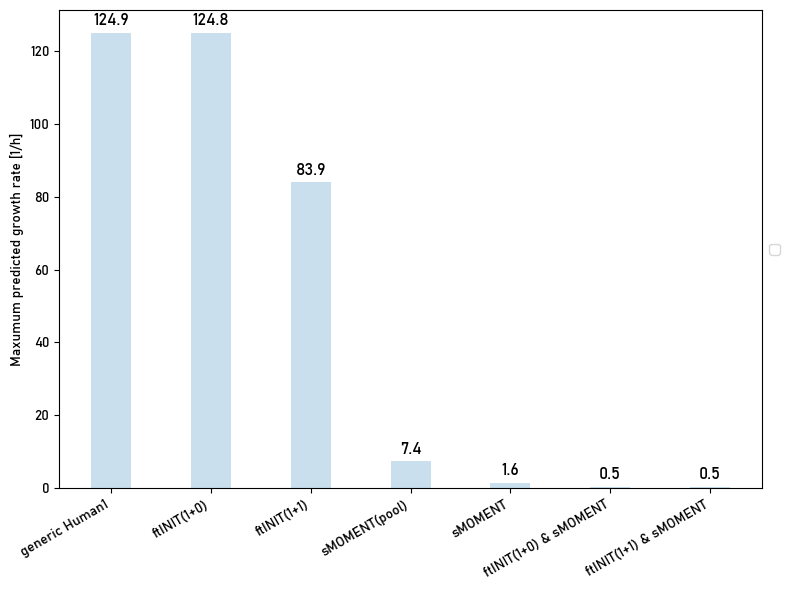

In [46]:
# Extract labels and values
# labels are the same as specified above
values = list(fba_solutions.values())

# Set font globally
plt.rcParams["font.family"] = "Bahnschrift"

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create bar plot
bars = ax.bar(labels, values, color="#BCD7E9", alpha=0.8, width=0.4)

# Add text annotations on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}", 
            ha="center", va="bottom", fontsize=12, fontname="Bahnschrift")

# Setting labels and styling
ax.set_xticklabels(labels, rotation=30, ha="right", fontname="Bahnschrift")
ax.set_ylabel("Maxumum predicted growth rate [1/h]", fontname="Bahnschrift")

# Move legend to center right, outside the plot
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent clipping
plt.tight_layout()
plt.savefig(current_dir.parent / "outputs" / "fba_barplot.svg")
plt.show()


In [35]:
fva_comparison = pd.DataFrame(
    {
        "Maximum growth rate": fba_solutions.values(),
        "Mean": means,
        "Q1": q1,
        "Median": medians,
        "Q3": q3,
        "Number of Reactions": [len(d) for d in rxn_variability],
        "Number of reactions with flux-range 1000": [sum([int(rxn_range == 1000) for rxn_range in d]) for d in rxn_variability],
        "Number of reactions with flux-range 2000": [sum([int(rxn_range == 2000) for rxn_range in d]) for d in rxn_variability],

    },
    index=labels
)
fva_comparison["Number of default constrained reactions"] = fva_comparison["Number of reactions with flux-range 1000"] + fva_comparison["Number of reactions with flux-range 2000"]
fva_comparison.to_csv(current_dir.parent / "outputs" / "fva_comparison_stats.tsv", sep="\t")
fva_comparison

,Maximum growth rate,Mean,Q1,Median,Q3,Number of Reactions,Number of reactions with flux-range 1000,Number of reactions with flux-range 2000,Number of default constrained reactions
generic Human1,124.868148,847.106486,116.666667,1000.000000,1180.643922,12971,3076,2150,5226
ftINIT(1+0),124.829128,697.119567,70.000000,350.400000,1000.000000,8577,1924,1082,3006
ftINIT(1+1),83.865700,466.565004,13.895467,127.669838,1000.000000,7986,1085,672,1757
sMOMENT(pool),7.412502,606.775014,0.805005,33.771477,1000.000000,12971,1648,2202,3850
sMOMENT,1.564703,407.760122,0.159099,7.080727,811.641350,12971,566,659,1225
ftINIT(1+0) & sMOMENT,0.475333,304.646902,0.043410,1.657280,321.594534,8577,222,440,662
ftINIT(1+1) & sMOMENT,0.487000,300.370556,0.022121,0.901899,23.819470,7986,418,827,1245
